In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# Import data and convert date
date_parse = lambda x: pd.datetime.strptime(x, '%b %d, %Y')
df = pd.read_csv("data/oil prices/BrentOilPrices.csv", parse_dates=['Date'], date_parser=date_parse)
df = df.sort_values('Date')
df = df.groupby('Date')['Price'].sum().reset_index()
df.set_index('Date', inplace=True)
df = df.loc[datetime.date(year=2000,month=1,day=1):]
df.head()

,Price
Date,
2000-01-04,23.95
2000-01-05,23.72
2000-01-06,23.55
2000-01-07,23.35
2000-01-10,22.77


In [3]:
# Check nulls
df.isna().sum()

Price    0
dtype: int64

In [4]:
# Check dates
df.index

DatetimeIndex(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
               '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13',
               '2000-01-14', '2000-01-17',
               ...
               '2019-09-17', '2019-09-18', '2019-09-19', '2019-09-20',
               '2019-09-23', '2019-09-24', '2019-09-25', '2019-09-26',
               '2019-09-27', '2019-09-30'],
              dtype='datetime64[ns]', name='Date', length=5016, freq=None)

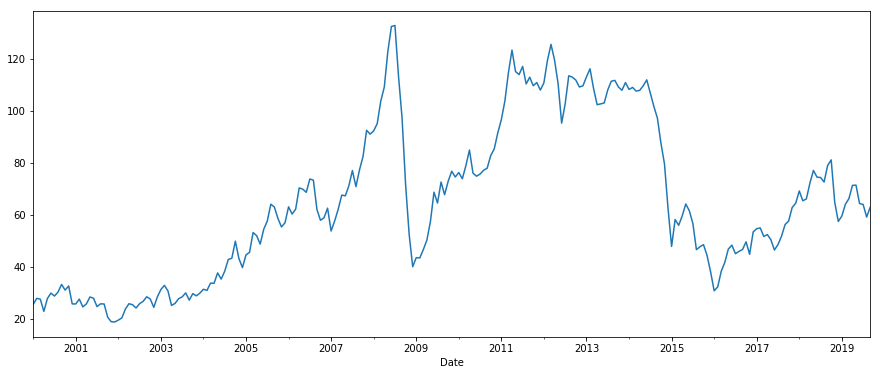

In [5]:
# Plot means of months of prices
df['Price'].resample('MS').mean().plot(figsize=(15, 6))

In [6]:
# Normalize data
sc = MinMaxScaler(feature_range=(0, 1))
df = sc.fit_transform(df)

In [7]:
# Split data
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

In [8]:
# Create x_train, x_test, y_train, y_test
def create_data_set(data_set):
    data_x, data_y = [], []
    for i in range(len(data_set) - 90 - 1):
        data_x.append(data_set[i:(i + 90), 0])
        data_y.append(data_set[i + 90, 0])
    return np.array(data_x), np.array(data_y)

x_train, y_train = create_data_set(train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test, y_test = create_data_set(test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [9]:
# Create and fit model
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=60))
model.add(Dropout(0.1))
model.add(Dense(units = 1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=20, batch_size=15, validation_data=(x_test, y_test), shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 3420 samples, validate on 1414 samples
Epoch 1/20
3420/3420 [==============================] - 86s 25ms/step - loss: 0.0056 - val_loss: 0.0652
Epoch 2/20
3420/3420 [==============================] - 77s 23ms/step - loss: 0.0139 - val_loss: 0.1067
Epoch 3/20
3420/3420 [==============================] - 78s 23ms/step - loss: 0.0198 - val_loss: 0.0929
Epoch 4/20
3420/3420 [==============================] - 78s 23ms/step - loss: 0.0197 - val_loss: 0.0613
Epoch 5/20
3420/3420 [==============================] - 78s 23ms/step - loss: 0.0065 - val_loss: 0.0017
Epoch 6/20
3420/3420 [==============================] - 77s 23ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 7/20
3420/3420 [==============================] - 78s 23ms/step - loss: 0.0014 - val_lo

In [10]:
# Predict and inverse min-max scaler
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

train_predict = sc.inverse_transform(train_predict)
y_train = sc.inverse_transform([y_train])
test_predict = sc.inverse_transform(test_predict)
y_test = sc.inverse_transform([y_test])

Train MSE: 7.242283858840137
Test MSE: 7.259889204469394


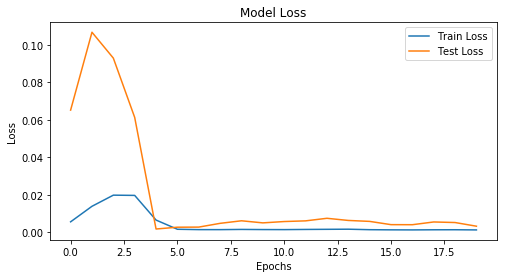

In [11]:
# Print errors and plot model train graphs
print('Train MSE:', np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0])))
print('Test MSE:', np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0])))
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

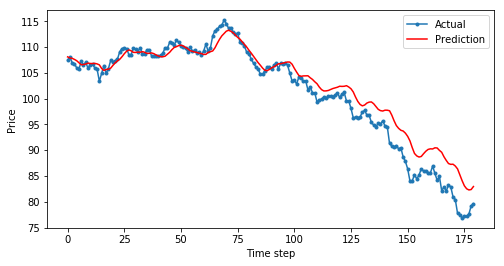

In [12]:
# Compare real and predicted values
time_step = [i for i in range(180)]
plt.figure(figsize=(8, 4))
plt.plot(time_step, y_test[0][:180], marker='.', label="Actual")
plt.plot(time_step, test_predict[:,0][:180], 'r', label="Prediction")
plt.ylabel('Price')
plt.xlabel('Time step')
plt.legend()